<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Introduction </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<div style="margin: 20px; padding: 10px; border-left: 5px solid #2c3e50; background-color: #ecf0f1;">
    <p style="font-size: 16px; text-align: justify; color: #34495e;">
In this report, I dive into the evolving landscape of Facebook Live selling in Thailand, a market that stands at the forefront of social media commerce. The introduction and adoption of Facebook Live have transformed the way sellers engage with their audience, introducing a novel, dynamic form of interaction that has significantly impacted engagement patterns. The study leverages a dataset encompassing Facebook posts from Thai fashion and cosmetics retailers, spanning from 2012 to 2018, to unravel the nuances of customer engagement across various forms of content, with a particular focus on video content. This rich dataset, described in detail by Nassim Dehouche, provides an unparalleled opportunity to explore the shifts in engagement strategies and outcomes in the realm of Thai social commerce, shedding light on the comparative performance of videos versus traditional media types like text, images in garnering reactions such as likes, loves, and comments.
        
   <p style="font-size: 16px; text-align: justify; color: #34495e;">
I focus on understanding how videos, especially live ones, engage customers on Facebook. To do this, I use two main tools: Principal Component Analysis (PCA) and k-means clustering. With PCA, I simplify the complex data on how people react to posts — like how many are liking, loving, or commenting—into clearer patterns. This helps see what really gets people's attention. Then, using k-means clustering, I group the audience into categories based on how they interact with these posts. This step shows us the different ways people respond to live videos compared to regular posts. By doing this, I find out what makes live videos special for engaging with the audience. This is super important for businesses in Thailand using Facebook to connect with their customers. The goal of my report is to make it easier for these businesses to see the value of live videos and how they can use them better to bring their online communities together.   </p>
    </p>
    </div>

In [1]:
# Standard libraries
import numpy as np                   # Mathematical essentials
import pandas as pd                  # Data science essentials
import matplotlib.pyplot as plt      # Essential graphical output
import seaborn as sns                # Enhanced graphical output

# Preprocessing
from sklearn.preprocessing import StandardScaler  # Standard scaler
from sklearn.preprocessing import PowerTransformer # Power transformation (Yeo-Johnson)

# Model development
from sklearn.decomposition import PCA            # Principal Component Analysis (PCA)
from sklearn.linear_model import LogisticRegression # Logistic regression

# Model evaluation
from sklearn.metrics import roc_auc_score        # ROC AUC score
from sklearn.metrics import confusion_matrix     # Confusion matrix
from sklearn.model_selection import train_test_split # Splitting data into training and testing sets

# Clustering and hierarchical modeling
from scipy.cluster.hierarchy import dendrogram, linkage # Hierarchical clustering
from sklearn.cluster import KMeans                # K-Means clustering

# loading data
fb_data = pd.read_excel(io = './datasets/facebook_live_data.xlsx')
fb_data.head()

,status_id,status_type,time_published,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,1,video,2018-04-22 06:00:00,512,262,432,92,3,1,1,0
1,2,photo,2018-04-18 03:22:00,0,0,204,9,0,0,0,0
2,3,video,2018-04-18 00:24:00,614,72,418,70,10,2,0,3
3,4,photo,2018-04-11 04:53:00,9,1,167,3,0,0,0,0
4,5,photo,2018-04-09 02:06:00,4,0,213,5,4,0,0,0


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Missing Value Analysis & Imputation </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [2]:
# Checking the missing values for the features
fb_data.isnull().sum()

# No missing values were reported in the data

status_id         0
status_type       0
time_published    0
num_comments      0
num_shares        0
num_likes         0
num_loves         0
num_wows          0
num_hahas         0
num_sads          0
num_angrys        0
dtype: int64

In [3]:
########################################
# scree_plot
########################################
def scree_plot(pca_object, cutoff=None):
    """
    Visualizes a scree plot from a pca object and includes a cutoff line.
    
    PARAMETERS
    ----------
    pca_object | A fitted pca object
    cutoff     | The cutoff point for the number of components to retain
    
    """
    # building a scree plot
    # setting plot size
    fig, ax = plt.subplots(figsize=(10, 8))
    features = range(pca_object.n_components_)

    # developing a scree plot
    plt.plot(features,
             pca_object.explained_variance_ratio_,
             linewidth=2,
             marker='o',
             markersize=10,
             markeredgecolor='black',
             markerfacecolor='grey')

    # setting more plot options
    plt.title('Scree Plot')
    plt.xlabel('PCA feature')
    plt.ylabel('Explained Variance')
    plt.xticks(features)
    
    # Drawing the cutoff line if specified
    if cutoff:
        plt.axvline(x=cutoff - 1, color='red', linestyle='--') # subtracting 1 for zero indexing
    
    # displaying the plot
    plt.show()
    
########################################
# unsupervised_scaler
########################################
def scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Feature Engineering & Exploratory Data Analysis </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [4]:
fb_data.shape
# The dataset contains 2297 observations and has 11 features

(2297, 11)

In [5]:
# Extracting the datetime features from time_published
fb_data['time_published'] = pd.to_datetime(fb_data['time_published'])

In [6]:
# Extracting features from time_published
fb_data['hour'] = fb_data['time_published'].dt.hour
fb_data['year'] = fb_data['time_published'].dt.year
fb_data['day_of_week'] = fb_data['time_published'].dt.dayofweek
fb_data['month'] = fb_data['time_published'].dt.month
fb_data['day_of_month'] = fb_data['time_published'].dt.day

In [7]:
# Convert 'hour' into 'time_of_day'
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Feature 1 - Time of the day
fb_data['time_of_day'] = fb_data['hour'].apply(categorize_hour)

# Feature 2 - Weekend or not
# Convert 'day_of_week' into 'weekend' (0: Weekday, 1: Weekend)
fb_data['is_weekend'] = fb_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Convert 'month' into 'season'
def categorize_season(month):
    if 3 <= month < 6:
        return 'Spring'
    elif 6 <= month < 9:
        return 'Summer'
    elif 9 <= month < 12:
        return 'Autumn'
    else: # December to February
        return 'Winter'

# Feature 3 - Season
fb_data['season'] = fb_data['month'].apply(categorize_season)

# Summing up the emotional reactions
fb_data['emotional_reactions'] = fb_data['num_loves'] + fb_data['num_wows'] + fb_data['num_hahas'] + fb_data['num_sads'] + fb_data['num_angrys']

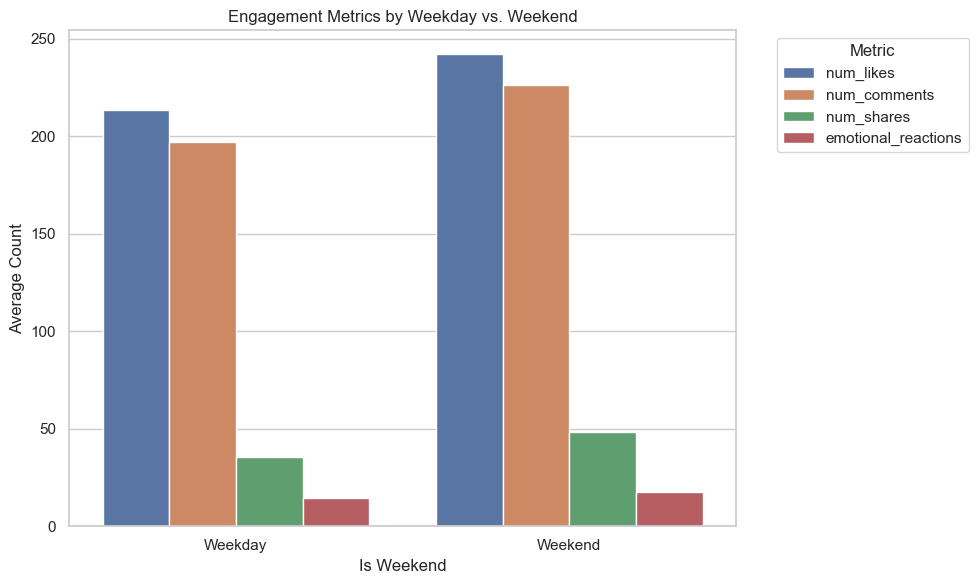

In [8]:
# Weekday vs. Weekend
# Aggregating metrics for weekdays and weekends
weekend_engagement = fb_data.groupby('is_weekend').agg({'num_likes': 'mean', 
                                                        'num_comments': 'mean', 
                                                        'num_shares': 'mean',
                                                        'emotional_reactions': 'mean'}).reset_index()

# Melting for visualization
weekend_engagement_melted = pd.melt(weekend_engagement, id_vars=['is_weekend'],
                                    value_vars=['num_likes', 'num_comments', 'num_shares', 'emotional_reactions'],
                                    var_name='Metric', value_name='Value')

# Plotting 
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  
barplot = sns.barplot(x='is_weekend', y='Value', hue='Metric', data=weekend_engagement_melted)
plt.title('Engagement Metrics by Weekday vs. Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Average Count')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc=2)  
plt.tight_layout()
plt.show()

From the graph, it is evident that the weekends command a significantly higher user engagement on all fronts compared to weekdays. This trend is particularly relevant to the Thai market, which is at the forefront of integrating social media, especially Facebook Live, into their commerce activities. The heightened engagement during weekends suggests that Thai consumers are more inclined to interact with Facebook Live content when they have fewer professional commitments. This provides valuable insight for sellers in this market; knowing that their audience is more responsive during weekends, they could strategically schedule their most compelling live content and promotional activities to maximize viewership and interaction, thereby increasing sales opportunities.

The rise in emotional reactions on weekends also deserves attention, as it suggests a deeper level of consumer engagement that goes beyond mere likes. For Thai Facebook Live sellers, this could imply that the immersive and interactive nature of live videos is particularly effective during weekends when users are more available to express varied emotions. Leveraging this, sellers could present emotionally charged content, such as limited-time offers or interactive sessions, to enhance viewer participation and potentially drive higher sales.

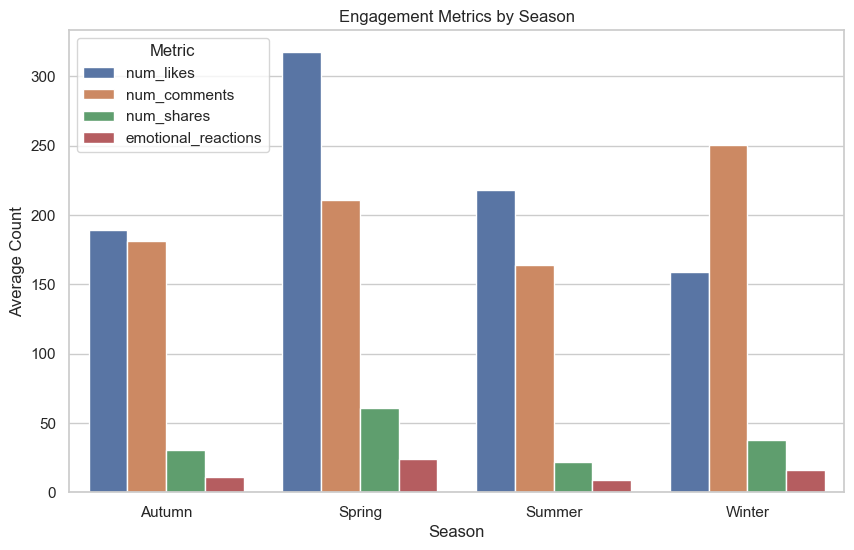

In [9]:
# Seasonal Engagement
# Aggregating engagement metrics by season
season_engagement = fb_data.groupby('season').agg({'num_likes': 'mean', 
                                                   'num_comments': 'mean', 
                                                   'num_shares': 'mean',
                                                   'emotional_reactions': 'mean'}).reset_index()

# Melting for visualization
season_engagement_melted = pd.melt(season_engagement, id_vars=['season'],
                                   value_vars=['num_likes', 'num_comments', 'num_shares', 'emotional_reactions'],
                                   var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='Value', hue='Metric', data=season_engagement_melted)
plt.title('Engagement Metrics by Season')
plt.xlabel('Season')
plt.ylabel('Average Count')
plt.legend(title='Metric')
plt.show()

The graph shows that emotional reactions peak in the spring season, suggesting that content shared during this time may resonate more deeply with emotions, potentially due to seasonal marketing campaigns or holiday-related content. Meanwhile, the number of likes is also highest in the spring, indicating that this might be the season when users are most receptive to content, possibly engaging with new product launches or spring collections. Comments and shares have less seasonal fluctuation, suggesting that these engagement types are more consistent throughout the year.

For Facebook Live sellers in Thailand, leveraging these insights can be transformative. By tailoring their content strategies to these engagement patterns—like focusing on emotionally charged content and like-eliciting content in spring—they can potentially amplify their reach and engagement, thus increasing the chances for higher sales conversions. Understanding the nuances of customer interaction across different seasons is crucial in a highly competitive market like Thailand, where social media plays a pivotal role.

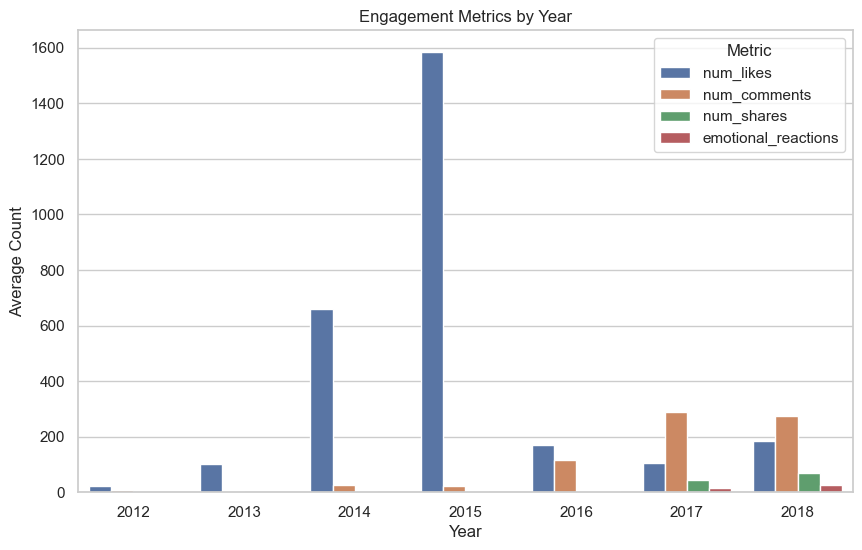

In [10]:
# Aggregating metrics by year
year_engagement = fb_data.groupby('year').agg({'num_likes': 'mean', 
                                               'num_comments': 'mean', 
                                               'num_shares': 'mean',
                                               'emotional_reactions': 'mean'}).reset_index()

# Melting for visualization
year_engagement_melted = pd.melt(year_engagement, id_vars=['year'],
                                  value_vars=['num_likes', 'num_comments', 'num_shares', 'emotional_reactions'],
                                  var_name='Metric', value_name='Value')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='Value', hue='Metric', data=year_engagement_melted)
plt.title('Engagement Metrics by Year')
plt.xlabel('Year')
plt.ylabel('Average Count')
plt.legend(title='Metric')
plt.show()

A noticeable peak in likes is seen in 2015, which could suggest an event or a change in platform algorithms or user behavior that caused a surge in activity. For sellers, understanding the context behind this spike is crucial—it could be due to the increasing popularity of Facebook as a commerce tool or a market trend that particularly resonated with consumers.

Following 2015, there is a visible decline in likes, which could reflect market saturation, changes in consumer behavior, or shifts towards other platforms or media types for engagement. However, emotional reactions, a metric introduced by Facebook in 2016, are shown from 2016 onwards, and it's notable that these reactions have a different trend than the other metrics, potentially signaling a shift in how users engage with content.

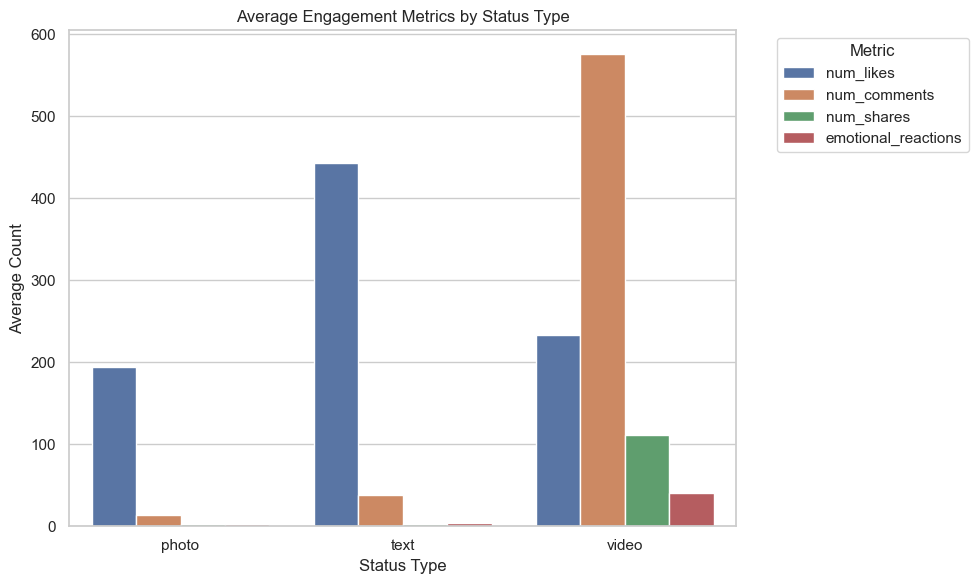

In [11]:
# Aggregating metrics for different status types
status_type_engagement = fb_data.groupby('status_type').agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'
}).reset_index()

# Melting for visualization
status_type_engagement_melted = pd.melt(status_type_engagement, id_vars=['status_type'],
                                        value_vars=['num_likes', 'num_comments', 'num_shares', 'emotional_reactions'],
                                        var_name='Metric', value_name='Value')

# Plotting 
plt.figure(figsize=(10, 6))
sns.barplot(x='status_type', y='Value', hue='Metric', data=status_type_engagement_melted)
plt.title('Average Engagement Metrics by Status Type')
plt.xlabel('Status Type')
plt.ylabel('Average Count')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

It is apparent that videos garner significantly higher engagement in comments, shares, and emotional reactions compared to photos and text posts.

For Thai Facebook Live sellers, this information is critical as it highlights the effectiveness of video content in driving audience interaction. The visual and dynamic nature of video content likely resonates more with users, prompting higher levels of engagement. Sellers can leverage this insight by prioritizing live video content to showcase products, host live Q&A sessions, and create interactive experiences that could lead to increased customer interest and potentially higher sales. With video being such a powerful medium for connection, it's a strategic tool that sellers can utilize to differentiate themselves in a competitive online marketplace.

In [12]:
# Updating the DataFrame with the engagement metrics calculation
average_engagement_by_content_type = fb_data.groupby('status_type')[['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']].mean()

# Calculating the sum of reactions other than likes (emotional reactions)
average_engagement_by_content_type['sum_emotional_reactions'] = average_engagement_by_content_type[['num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']].sum(axis=1)

# Calculating total engagement (sum of all reactions) for each content type for comparison
average_engagement_by_content_type['total_engagement'] = average_engagement_by_content_type['num_likes'] + average_engagement_by_content_type['sum_emotional_reactions']

# Rounding the values for clearer presentation
average_engagement_rounded = average_engagement_by_content_type.round(2)
average_engagement_rounded

,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,sum_emotional_reactions,total_engagement
status_type,,,,,,,,
photo,194.11,1.43,0.69,0.17,0.14,0.02,2.46,196.56
text,442.37,1.97,1.40,0.10,0.25,0.04,3.76,446.13
video,232.99,35.63,2.94,1.52,0.44,0.25,40.78,273.77


The engagement metrics across different content types on Facebook offer valuable insights into how videos perform relative to photos and text in terms of reactions and total engagement:

1. Videos significantly outperform photos and text posts in generating emotional reactions (loves, wows, hahas, sads, angrys), with a total of 40.78 emotional reactions on average. This is markedly higher than the 2.46 for photos and 3.76 for text posts, underscoring videos' ability to evoke a broader and more intense emotional response from viewers.

2. Text posts lead significantly in likes (442.37), which contributes to their highest total engagement (446.13) among the content types. This suggests that while text posts may not elicit as wide a range of emotional reactions, they are highly effective in garnering attention and approval from the audience.

3. Despite having fewer likes than text posts (232.99), videos' strong performance in emotional reactions boosts their total engagement to 273.77. This indicates a balanced engagement profile, where videos may not always capture the highest initial attention (as measured by likes) but excel in engaging the audience deeply through a variety of emotional responses.

4. Photos, while not leading in any specific category of engagement, still maintain a respectable level of likes (194.11) and total engagement (196.56). Moreover, the summary table highlights the strategic value of videos for driving deeper, more varied forms of engagement beyond mere likes. Videos' ability to garner loves, wows, hahas, sads, and angrys at a higher rate than photos and text posts makes them a powerful tool for creating lasting impressions.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Principal Component Analysis </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

__Likes:__ The most basic form of engagement, indicating general approval. <br/>
__Loves:__ A stronger form of approval, indicating deeper affection for the content.  <br/>
__Wows:__ Signify surprise or amazement, indicating content that stands out. <br/>
__Hahas:__ Reflect amusement, showing content that entertains. <br/>
__Sads:__ Indicate empathy or sadness, often for more serious or touching content. <br/>
__Angrys:__ Show discontent or disagreement, often sparked by controversial content. <br/>
__Comments:__ Represent a higher level of engagement, as they require more effort from users and indicate that the content prompted them to express their thoughts. <br/>
__Shares:__ Signify the highest level of engagement, as users are distributing the content to their network, indicating they found it valuable or worth spreading. <br/>

I chose these features for PCA to capture a comprehensive picture of social media engagement, encompassing both the breadth (likes, shares) and depth (comments, specific reactions) of user interactions.

In [13]:
# Selecting metrics for PCA and standardizing the data
metrics = ['num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'num_comments', 'num_shares']

# Calculating skewness for the selected features before performing PCA
skewness = fb_data[metrics].skew().round(decimals = 2)
skewness

num_likes        3.72
num_loves        5.97
num_wows        15.62
num_hahas       16.93
num_sads        17.12
num_angrys      10.59
num_comments    10.14
num_shares       6.17
dtype: float64

In [14]:
# Initialize the PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform the data
transformed_data = pt.fit_transform(fb_data[metrics])

# Creating a DataFrame for the transformed data
transformed_df = pd.DataFrame(transformed_data, columns=metrics)

# Calculating the skewness of the transformed data
transformed_skewness = transformed_df.skew().round(decimals = 2)
transformed_skewness

num_likes      -0.00
num_loves       0.68
num_wows        1.15
num_hahas       1.80
num_sads        3.07
num_angrys      3.79
num_comments    0.26
num_shares      0.69
dtype: float64

In [15]:
np.var(transformed_df)

num_likes       1.0
num_loves       1.0
num_wows        1.0
num_hahas       1.0
num_sads        1.0
num_angrys      1.0
num_comments    1.0
num_shares      1.0
dtype: float64

The Yeo-Johnson transformation has standardized the dataset, achieving a variance of 1.0 across all features, which mirrors the objective of the StandardScaler. This transformation not only addresses skewness but also scales the data, rendering additional scaling unnecessary for PCA. Given this, I'm bypassing the StandardScaler step, as the dataset already meets the precondition of equal variance among features, ensuring that PCA can proceed without bias towards any disproportionately scaled variable.

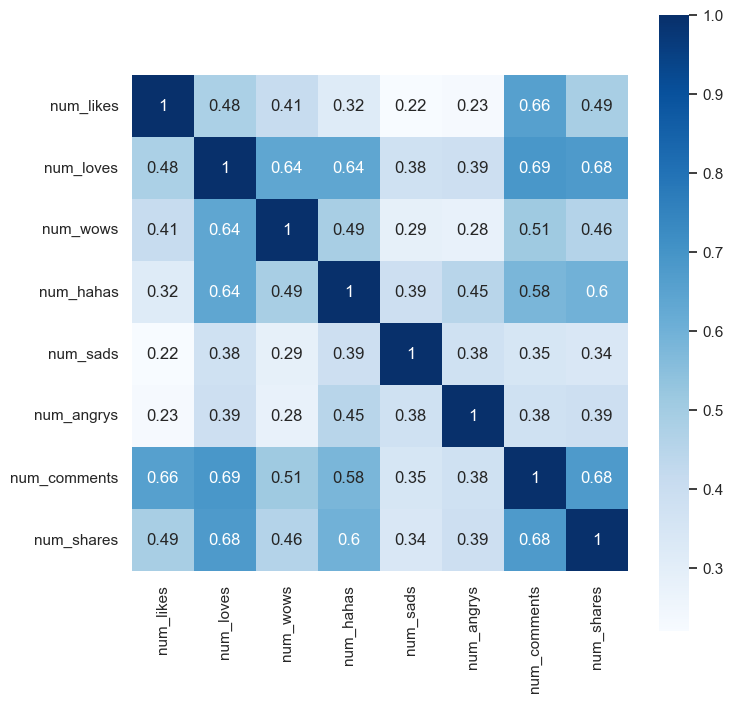

In [16]:
# Setting plot size
fig, ax = plt.subplots(figsize=(8, 8))

# Developing a correlation matrix object for the transformed dataset
df_corr = transformed_df.corr(method='pearson').round(decimals=2)

# Creating a correlation heatmap using seaborn
sns.heatmap(data=df_corr,
            cmap='Blues',
            square=True,
            annot=True)

# Rendering the heatmap
plt.show()

The correlation heatmap of the social media engagement metrics exhibits a range of correlation strengths, with several moderate correlations interspersed with lower ones, and no extremely high correlations dominating the matrix. This pattern is indicative of a dataset where features share some common information but also retain unique characteristics. For instance, the notable correlations between num_likes and num_comments (0.66), num_loves and num_comments (0.69), as well as num_loves and num_wows (0.64), suggest shared variance that PCA can capture in fewer components. 

Meanwhile, the relatively lower correlations involving num_sads and num_likes (0.22) suggest these features may contribute distinct information to the principal components, enhancing the PCA's ability to reduce dimensionality while preserving the dataset's nuanced structure. The absence of near-perfect correlations confirms that multicollinearity is not a concern for our features, making PCA a suitable method to identify and condense the underlying factors driving engagement without significant loss of information.

In [17]:
# INSTANTIATING a PCA object with no limit to principal components
pca = PCA(n_components = None,
            random_state = 702)

# FITTING and TRANSFORMING the scaled data
transformed_pca = pca.fit_transform(transformed_df)

# comparing dimensions of each DataFrame
print("Original shape:", transformed_df.shape)
print("PCA shape     :", transformed_pca.shape)

Original shape: (2297, 8)
PCA shape     : (2297, 8)


In [18]:
# component number counter
component_number = 0

# looping over each principal component
for variance in pca.explained_variance_ratio_:
    component_number += 1
    
    print(f"PC {component_number}: {variance.round(2)}")
    
variance_ratio = pca.explained_variance_ratio_

PC 1: 0.54
PC 2: 0.12
PC 3: 0.08
PC 4: 0.08
PC 5: 0.07
PC 6: 0.05
PC 7: 0.03
PC 8: 0.03


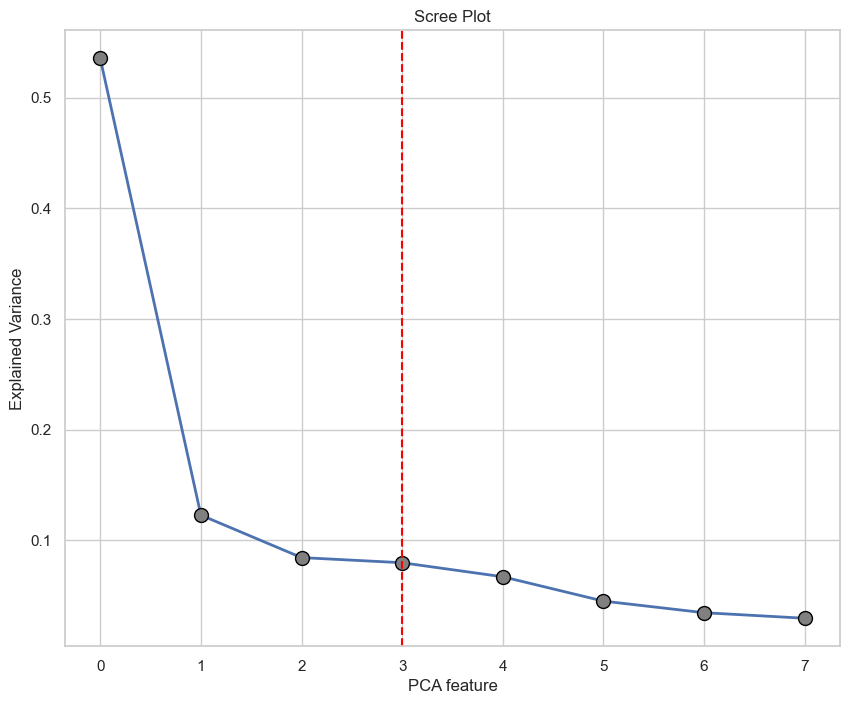

In [19]:
# Generating the scree plot
scree_plot(pca_object = pca, cutoff = 4)

In [20]:
# Getting the factor loadings
factor_loadings = pd.DataFrame(pca.components_.T, index=transformed_df.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)]).round(2)

# Displaying the factor loadings 
factor_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
num_likes,0.32,-0.48,0.58,-0.05,0.25,0.27,0.23,0.38
num_loves,0.42,-0.09,-0.27,-0.05,-0.06,-0.24,-0.63,0.53
num_wows,0.34,-0.15,-0.53,-0.30,0.60,-0.08,0.28,-0.22
num_hahas,0.38,0.19,-0.35,0.16,-0.35,0.72,0.18,0.08
num_sads,0.26,0.57,0.32,-0.70,-0.10,-0.04,0.03,0.00
num_angrys,0.28,0.56,0.21,0.59,0.47,-0.09,-0.02,0.02
num_comments,0.41,-0.23,0.23,0.06,-0.12,0.08,-0.42,-0.72
num_shares,0.39,-0.09,0.01,0.20,-0.46,-0.58,0.50,-0.01


__PC1__ captures a general positive engagement, as it has strong positive loadings for all types of reactions (likes, loves, wows, hahas, comments, shares). It could represent __"Overall Engagement"__.

__PC2__ shows a contrast between negative loadings for 'num_likes' and positive loadings for 'num_sads' and 'num_angrys', which might be indicative of polarizing content that generates strong emotional reactions. This could be labeled as __"Emotional Response"__.

__PC3__ appears to represent contrasting types of engagement with strong loadings for 'num_likes' and negative for 'num_wows' and 'num_hahas', possibly distinguishing between admiration and surprise/humor. This might be called __"Quality of Engagement"__.

__PC4__, with significant negative loadings for 'num_sads' and positive for 'num_angrys', may differentiate between types of negative reactions, indicating a __"Controversial Engagement"__.

Initally, I was considering to select 3 Principal Components based on the elbow in the scree plot. However, the justification for selecting four principal components over three, despite the visible elbow after the third component, lies in the qualitative interpretation of the fourth component. PC4 represents a different aspect of engagement not captured by the first three components — namely, the distinction between different types of negative reactions, which could be critical for nuanced social media strategy. Recognizing diverse negative reactions—such as "sads" versus "angrys"—can inform more targeted and effective communication tactics, distinguishing between content that may be seen as sad and empathetic versus that which might be perceived as frustrating or infuriating.  Also, in some contexts like customer feedback analysis, political campaigns during election years, brand reputation monitoring differentiating between different types of negative reactions can be just as valuable as understanding positive ones. Moreover, by taking 3 principal components the total explained variance was coming out to be 74% and taking 4 principal components its coming to be 82%, which follows our rule of thumb of selecting no. of components based on the cumulative sum of explained variance of all selected components to be 80%.

In [21]:
# Keeping only the first four principal components
factor_loadings_updated = factor_loadings.iloc[:, :4]

# Renaming the columns of the reduced factor loadings DataFrame
factor_loadings_updated.columns = ['Overall Engagement', 'Emotional Response', 'Quality of Engagement', 'Controversial Engagement']
factor_loadings_updated

,Overall Engagement,Emotional Response,Quality of Engagement,Controversial Engagement
num_likes,0.32,-0.48,0.58,-0.05
num_loves,0.42,-0.09,-0.27,-0.05
num_wows,0.34,-0.15,-0.53,-0.30
num_hahas,0.38,0.19,-0.35,0.16
num_sads,0.26,0.57,0.32,-0.70
num_angrys,0.28,0.56,0.21,0.59
num_comments,0.41,-0.23,0.23,0.06
num_shares,0.39,-0.09,0.01,0.20


In [22]:
# Converting to dataframe
transformed_pca_df = pd.DataFrame(transformed_pca).round(decimals = 2)

# Keeping only the first four principal components
transformed_pca_df = transformed_pca_df.iloc[:, :4]

# Renaming columns to reflect the persona names
transformed_pca_df.columns = ['Overall Engagement', 'Emotional Response', 'Quality of Engagement', 'Controversial Engagement']

In [23]:
# Define the percentile thresholds for each PCA component
high_threshold = transformed_pca_df.quantile(0.95)
low_threshold = transformed_pca_df.quantile(0.05)

# Initialize DataFrames to store high and low extremes
high_extremes_df = pd.DataFrame(index=transformed_pca_df.columns, columns=["95th Percentile Value"])
low_extremes_df = pd.DataFrame(index=transformed_pca_df.columns, columns=["5th Percentile Value"])

# Populate the DataFrames with the respective high and low threshold values for each component
for component in transformed_pca_df.columns:
    high_extremes_df.loc[component, "95th Percentile Value"] = high_threshold[component]
    low_extremes_df.loc[component, "5th Percentile Value"] = low_threshold[component]

# Calculating the count of posts meeting high and low extremes criteria
high_extremes_count = transformed_pca_df[transformed_pca_df > high_threshold].count()
low_extremes_count = transformed_pca_df[transformed_pca_df < low_threshold].count()

# Adding the counts to the respective DataFrames
high_extremes_df['Count'] = high_extremes_count
low_extremes_df['Count'] = low_extremes_count

In [24]:
# Display the High extremes
print("High Extremes Across PCA Components:")
high_extremes_df

High Extremes Across PCA Components:


,95th Percentile Value,Count
Overall Engagement,4.512,115
Emotional Response,1.502,115
Quality of Engagement,1.62,113
Controversial Engagement,0.754,115


In [25]:
# Display the low extremes
print("\nLow Extremes Across PCA Components:")
low_extremes_df


Low Extremes Across PCA Components:


,5th Percentile Value,Count
Overall Engagement,-2.16,112
Emotional Response,-1.43,114
Quality of Engagement,-1.35,114
Controversial Engagement,-1.642,115


__High Extremes__ <br/>
__Overall Engagement (4.512, Count: 115):__ Posts with high overall engagement scores signify the peak performers in capturing audience attention and interaction. For Thai sellers, this insight underscores the importance of identifying the commonalities among these posts, which may include the use of engaging narratives, optimal posting times, or compelling visual content. Such posts likely encapsulate the elements that resonate most with the audience, suggesting a blueprint for content that can consistently achieve high engagement levels.

__Emotional Response (1.502, Count: 115):__ High scores in emotional response highlight posts that excel in eliciting strong feelings, be it joy, love, or surprise. For Thai Facebook Live sellers, tapping into the emotional drivers of engagement becomes essential. Crafting content that connects on an emotional level—whether through storytelling, showcasing relatable experiences, or highlighting inspiring brand stories—can enhance viewer bonds and loyalty.

__Quality of Engagement (1.62, Count: 113):__ This reflects posts that not only attract interactions but do so in a manner indicating deep audience investment, like thoughtful comments or meaningful shares. In the Thai market, where conversational commerce thrives, sellers can leverage this insight by creating content that invites discussion, personal reflections, or community participation, fostering a sense of belonging among viewers.

__Controversial Engagement (0.754, Count: 115):__ Posts scoring high in controversial engagement engage audiences in debates or discussions. While this can significantly boost visibility and engagement, Thai sellers must navigate such content carefully, ensuring it aligns with brand values and contributes positively to community building. Such posts might include discussions on trending topics, viewer polls, or Q&A sessions that provoke thought without crossing into negativity.

__Low Extremes__ <br/>
__Overall Engagement (-2.16, Count: 112):__ Low scores in overall engagement indicate posts that struggle to capture audience interest. For sellers, analyzing these posts can reveal what to avoid or adjust, such as less engaging content formats, improper timing, or weak call-to-actions. This analysis can guide sellers in refining their content strategies to avoid low engagement pitfalls.

__Emotional Response (-1.43, Count: 114):__ Posts with low emotional response scores might lack the elements that typically resonate with viewers on an emotional level. Sellers should explore more emotionally charged content themes, or improve the emotional appeal of their product presentations and live interactions.

__Quality of Engagement (-1.35, Count: 114), Controversial Engagement (-1.642, Count: 115):__ Low scores here suggest a need to enhance the depth and positivity of engagement. Integrating interactive elements, such as live Q&As, engaging storytelling, or interactive polls, can elevate the quality and positivity of audience interactions, steering clear of divisive content.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> K-Means Clustering </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [26]:
# Applying the scaler function
transformed_scaled = scaler(transformed_pca_df)

# Time related features were also concatenated with transformed_pca_df for K-means clustering. However, in the cluster centroids, they
# were not giving any significant results. So, decided to keep them out for clustering. 

In [27]:
# checking pre- and post-scaling variance
print(np.var(transformed_pca_df), '\n\n')
print(np.var(transformed_scaled))

Overall Engagement          4.285274
Emotional Response          0.983688
Quality of Engagement       0.676476
Controversial Engagement    0.639054
dtype: float64 


Overall Engagement          1.0
Emotional Response          1.0
Quality of Engagement       1.0
Controversial Engagement    1.0
dtype: float64


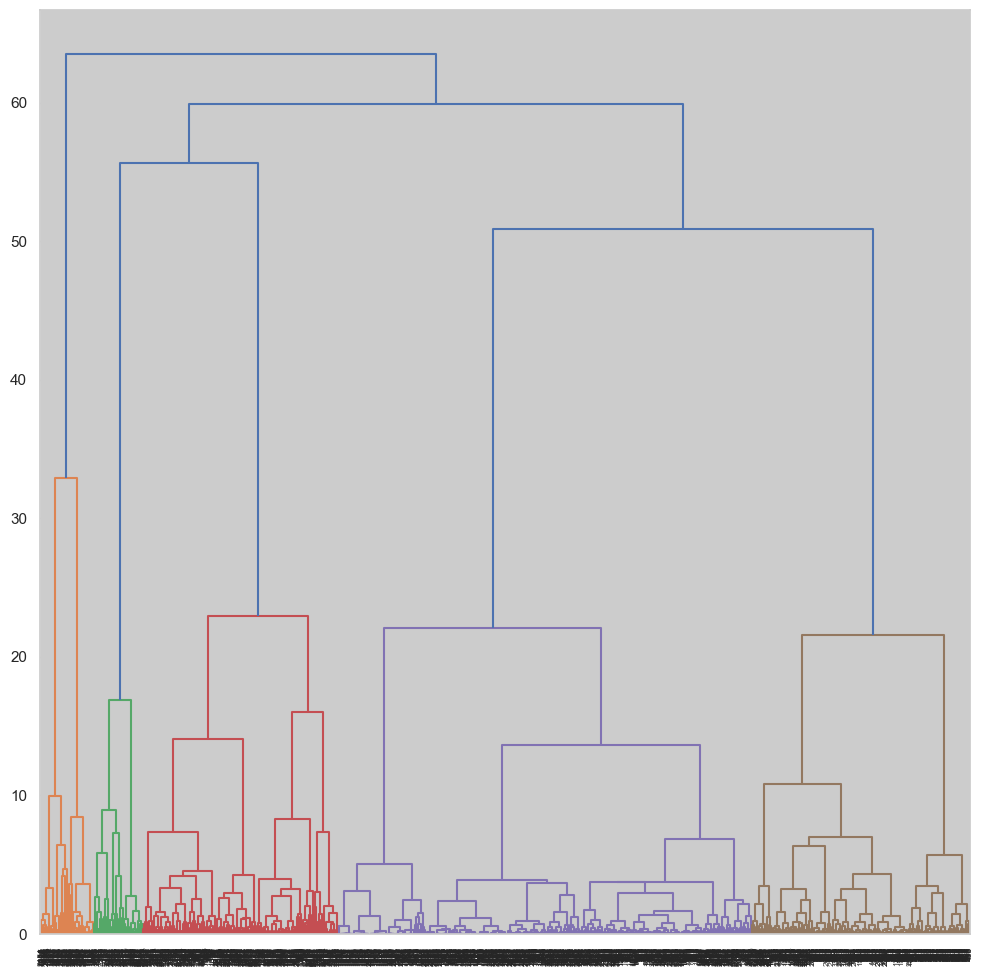

/Users/abhishekrathi/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Cluster
0    1571
2     473
1     133
3     120
Name: count, dtype: int64

In [28]:
# grouping data based on Ward distance
standard_mergings_ward = linkage(y = transformed_scaled,
                                 method = 'ward',
                                 optimal_ordering = True)

# setting plot size
fig, ax = plt.subplots(figsize=(12, 12))

# developing a dendrogram
dendrogram(Z = standard_mergings_ward,
           leaf_rotation  = 90,
           leaf_font_size = 6        )

# rendering the plot
plt.show()

# INSTANTIATING a k-Means object with 4 clusters
k_means = KMeans(n_clusters=4, 
                 n_init='auto', 
                 random_state=702)

# fitting the object to the data
k_means.fit(transformed_scaled)  

# converting the clusters to a DataFrame
kmeans_clusters = pd.DataFrame({'Cluster': k_means.labels_})

# Checking the results
cluster_counts = kmeans_clusters['Cluster'].value_counts().round(decimals = 2)
cluster_counts

The dendrogram produced by hierarchical clustering offers a visual representation of the data's structure and the potential cluster merges. In our case, the dendrogram indicates a clear distinction between 4 primary groups, as evidenced by the notable height of the links that form just before the last four merges. This suggests that combining clusters beyond this point would bridge significant dissimilarities in the data, which are otherwise well-differentiated at the 4 cluster level.

The decision not to opt for three clusters is supported by the dendrogram’s visible gap preceding the formation of the fourth cluster, indicating a substantial difference in cohesion that would be lost by merging into three. On the other hand, moving to five clusters does not show a similarly significant increase in structure definition, which would imply that the additional complexity of a fifth cluster might not offer as much interpretive value.

Moreover, the size distribution of the 4 clusters further justifies this choice. The largest cluster, Cluster 0, encompasses a majority with 1571 data points, while Clusters 2, 1, and 3 have 473, 133, and 120 points, respectively. Although there is a sizeable variation, each cluster is populous enough to be statistically robust, suggesting distinct subgroup characteristics within the data.

Given these points, 4 clusters provide a meaningful compromise between too few clusters, which might overlook important subgroup nuances, and too many, which could fragment the data into less actionable insights.

In [29]:
# Retrieving cluster centers
centroids = k_means.cluster_centers_

# converting cluster centers into a DataFrame
centroids_df = pd.DataFrame(centroids).round(decimals = 2)

# Assigning column names to the centroids DataFrame
feature_names = ['Overall Engagement', 'Emotional Response', 'Quality of Engagement',
                 'Controversial Engagement']
centroids_df.columns = feature_names
centroids_df

,Overall Engagement,Emotional Response,Quality of Engagement,Controversial Engagement
0,-0.55,0.02,0.21,0.14
1,2.30,2.23,0.68,1.89
2,0.83,-1.00,-1.05,-0.21
3,1.33,1.20,0.68,-3.06


Based on the centroid values for each cluster, we can interpret each segment as follows:

__Segment 1: "Casual Browsers"__
Cluster 0 presents lower 'Overall Engagement' (-0.55) score, which indicates that posts here generally receive less interaction than the norm. The near-zero 'Emotional Response' (0.02) and slightly positive 'Quality of Engagement' (0.21) suggest that while interactions are not highly emotive, they are not negative either. 'Controversial Engagement' (0.14) being close to zero implies minimal contentious discussion. A standard post might be a basic status update that accrues a few likes and occasional comments but doesn’t inspire strong reactions or become a hotbed for debate.

Example Post: A photo of a home-cooked meal with a simple caption like "Made spaghetti tonight #HomeCooking." This type of post is relatable to many, likely to garner a few likes and comments from close friends or followers who appreciate or enjoy similar meals, but it won't spark widespread engagement or strong emotional reactions.

__Segment 2: "Impactful Storytellers"__
Cluster 1 scores highly on all fronts, with very strong 'Overall Engagement' (2.30) and 'Emotional Response' (2.23), suggesting that posts in this segment typically generate a lot of likes and positive reactions like loves and wows. The positive 'Quality of Engagement' (0.68) implies good interaction depth, and a high 'Controversial Engagement' (1.89) indicates these posts often stir up lively discussions, possibly leading to polarized views. A representative post could be an emotionally charged announcement or a compelling story that garners widespread attention.

Example Post: A heartwarming video of a surprise family reunion with the caption, "After two years of being apart, we finally got to surprise Grandma! Her reaction was priceless #FamilyReunion." This post combines emotional storytelling with visually compelling content, likely resulting in high engagement through emotional reactions, comments sharing personal stories, and shares that extend its reach.

__Segment 3: "Content Curators"__
The third segment represented by Cluster 2 has an above-average 'Overall Engagement' (0.83) but negative scores in 'Emotional Response' (-1.00) and 'Quality of Engagement' (-1.05), meaning that despite a decent number of interactions, the emotional depth and quality are lacking. Negative 'Controversial Engagement' (-0.21) suggests these posts don't typically provoke heated debates. A typical post here could be informative content that is acknowledged by likes but does not strongly resonate or compel users to express deeper sentiments or share opinions.

Example Post: An infographic detailing steps to reduce personal carbon footprint with a caption, "Every little bit helps! Here are easy ways you can make a difference for our planet #EcoFriendlyLiving." While this post provides valuable information and may accrue likes from individuals interested in sustainability, it's less likely to provoke strong emotional responses or divisive comments.

__Segment 4: "Harmonious Engagers"__
Given the very high negative score for "Controversial Engagement" (-3.06), this segment represents posts that, despite high engagement and emotional reactions, avoid polarizing the audience. The negative score in "Controversial Engagement" indicates these posts are less likely to incite the specific type of negative reactions (frustration or anger) that PC4 identifies. Therefore, the content here, while engaging and emotionally resonant, does not significantly divide or provoke the audience.

Example Post: A post sharing a breathtaking landscape photo with the caption, "Caught the sunrise this morning, and it reminded me there's beauty in every new beginning. Let's start the day with positivity! #Sunrise #NewBeginnings." This type of content, showcasing natural beauty and an uplifting message, is likely to draw positive engagement from a broad spectrum of viewers, eliciting likes, loves, and possibly shares, without encouraging divisive interactions.

In [30]:
# Define the new segment names
new_segment_names = {
    0: "Casual Browsers",
    1: "Impactful Storytellers",
    2: "Content Curators",
    3: "Harmonious Engagers"
}

# Rename the rows in centroids_df
centroids_df.rename(index=new_segment_names, inplace=True)

# Display the updated DataFrame
centroids_df

,Overall Engagement,Emotional Response,Quality of Engagement,Controversial Engagement
Casual Browsers,-0.55,0.02,0.21,0.14
Impactful Storytellers,2.30,2.23,0.68,1.89
Content Curators,0.83,-1.00,-1.05,-0.21
Harmonious Engagers,1.33,1.20,0.68,-3.06


In [31]:
# Merge Cluster Labels with Original Data
fb_data = fb_data.reset_index(drop=True)
kmeans_clusters = kmeans_clusters.reset_index(drop=True)
fb_data_with_clusters = pd.concat([fb_data, kmeans_clusters], axis=1)

# Filter for videos and Aggregate Video Metrics by Cluster
video_data = fb_data_with_clusters[fb_data_with_clusters['status_type'] == 'video']
video_engagement_by_cluster = video_data.groupby('Cluster').agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'  
}).reset_index().round(2)

video_engagement_by_cluster['Cluster'] = video_engagement_by_cluster['Cluster'].map(new_segment_names)

# Aggregating total engagement metrics by status_type and Cluster
engagement_by_type_and_cluster = fb_data_with_clusters.groupby(['Cluster', 'status_type']).agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'  
}).reset_index().round(2)

engagement_by_type_and_cluster['Cluster'] = engagement_by_type_and_cluster['Cluster'].map(new_segment_names)

# Time of Day
time_of_day_analysis = video_data.groupby(['Cluster', 'time_of_day']).agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'
}).reset_index().round(2)

time_of_day_analysis['Cluster'] = time_of_day_analysis['Cluster'].map(new_segment_names)

# Is Weekend
weekend_analysis = video_data.groupby(['Cluster', 'is_weekend']).agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'
}).reset_index().round(2)

weekend_analysis['Cluster'] = weekend_analysis['Cluster'].map(new_segment_names)

# Season
season_analysis = video_data.groupby(['Cluster', 'season']).agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'
}).reset_index().round(2)

season_analysis['Cluster'] = season_analysis['Cluster'].map(new_segment_names)

# Year
year_analysis = video_data.groupby(['Cluster', 'year']).agg({
    'num_likes': 'mean',
    'num_comments': 'mean',
    'num_shares': 'mean',
    'emotional_reactions': 'mean'
}).reset_index().round(2)

year_analysis['Cluster'] = year_analysis['Cluster'].map(new_segment_names)

# Display the aggregated metrics 
print("Video Engagement by Cluster:\n", video_engagement_by_cluster.to_string(index=False))
print("\nEngagement by Status Type and Cluster:\n", engagement_by_type_and_cluster.to_string(index=False))
print("\nVideo Engagement by Time of Day:\n", time_of_day_analysis.to_string(index=False))
print("\nVideo Engagement by Weekend vs. Weekday:\n", weekend_analysis.to_string(index=False))
print("\nVideo Engagement by Season:\n", season_analysis.to_string(index=False))
print("\nVideo Engagement by Year:\n", year_analysis.to_string(index=False))

Video Engagement by Cluster:
                Cluster  num_likes  num_comments  num_shares  emotional_reactions
       Casual Browsers     197.60         19.57        6.75                 1.10
Impactful Storytellers     442.56       1502.88      328.97               133.80
      Content Curators     171.61        706.58      155.85                55.03
   Harmonious Engagers     230.52       1747.36      205.71                67.01

Engagement by Status Type and Cluster:
                Cluster status_type  num_likes  num_comments  num_shares  emotional_reactions
       Casual Browsers       photo     165.79          6.73        1.45                 0.47
       Casual Browsers        text     439.16         14.16        1.19                 0.78
       Casual Browsers       video     197.60         19.57        6.75                 1.10
Impactful Storytellers       photo     378.22         35.67        4.89                12.67
Impactful Storytellers        text     372.50         44.00

The exploration of video content across different audience segments provides a nuanced understanding of its impact within the Thai fashion and cosmetics retail space.

__The Storytelling Power of Videos:__
Impactful Storytellers stand out not just by their name but by the staggering engagement they muster — evidenced by an average of 1502.88 comments and 328.97 shares for video content. This segment's affinity for video underscores its role as a storytelling powerhouse, capable of eliciting profound emotional responses and fostering widespread message dissemination. The morning peaks in engagement suggest an audience eager to start their day with meaningful, compelling content, a strategic opportunity for brands to schedule their most impactful stories.

__Videos Capturing Casual Browsers' Attention:__
The Casual Browsers segment, characterized by its fleeting engagements, showcases an interesting pivot when it comes to video content. With videos achieving 19.57 comments and 6.75 shares, significantly higher than photos and text, it's evident that even the most passing of glances tend to pause longer on videos. This implies that videos, perhaps due to their dynamic nature, have the unique ability to break through the noise and capture the attention of even the most casual viewers.

__Niche Content and Curated Engagement:__
Content Curators present a paradigm of focused engagement, where videos, despite lower likes, encourage deep interaction — 706.58 comments and 155.85 shares. This segment's nuanced engagement with video content suggests a preference for videos that provide value, information, or cater to specific interests, affirming the importance of niche-targeted video content that resonates on a more personal level with its intended audience.

__Harmonious Engagers__ excel in utilizing videos to not just attract but significantly engage their audience, achieving 1747.36 comments and 205.71 shares. The role of videos in this segment aligns perfectly with their name—fostering harmony and community. Videos here likely embody uplifting, positive content that brings people together, evidenced further by their strong morning engagement and consistent interest throughout the year.

__Strategic Insights:__ 
Across the board, weekends emerge as a prime time for video engagement, suggesting audiences have more time and willingness to engage deeply with content. Seasonal trends reveal that while Impactful Storytellers bloom in spring, Harmonious Engagers maintain a steady volume of engagement year-round, highlighting the seasonal adaptability of video content strategies. Moreover, the upward trend in video engagement over the years speaks volumes about the growing importance of video in the social media landscape.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Logistic Regression Models</b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [32]:
# Initializing the target variable
fb_data['is_video'] = fb_data['status_type'].apply(lambda x: 1 if x == 'video' else 0)
fb_data_with_clusters['is_video'] = fb_data['is_video']

# Model 1: Using original x-features
# One-hot encoding for categorical variables and replacing True/False with 1/0
x_data_1 = pd.get_dummies(fb_data.drop(['status_id', 'status_type', 'time_published', 'is_video'], axis=1),
                          columns=['time_of_day', 'season'],
                          drop_first=True)
y_data_1 = fb_data['is_video']

# Splitting the dataset into training and testing sets for Model 1
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_data_1, y_data_1, test_size=0.25, random_state=42, stratify=y_data_1)

# Standardizing x_train_1 and x_test_1 using the scaler function
x_train_1_scaled = scaler(x_train_1)
x_test_1_scaled = scaler(x_test_1)

# Model 2: Using retained PCA components
x_data_2 = transformed_pca_df
y_data_2 = fb_data['is_video']

# Splitting the dataset into training and testing sets for Model 2
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_data_2, y_data_2, test_size=0.25, random_state=42, stratify=y_data_2)

# Model 3: Using retained clusters from K-means
x_data_3 = fb_data_with_clusters[['Cluster']]
y_data_3 = fb_data_with_clusters['is_video']

# Splitting the dataset into training and testing sets for Model 3
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_data_3, y_data_3, test_size=0.25, random_state=42, stratify=y_data_3)

In [33]:
# Generating the scores
def logistic_regression_evaluation(x_train, x_test, y_train, y_test):
    """
    Trains and evaluates a logistic regression model on given training and testing data.
    Returns training accuracy, testing accuracy, train-test gap, and AUC score.
    """
    # Initializing the logistic regression model with a higher iteration limit
    lr = LogisticRegression(max_iter=1000)
    
    # Fitting the model on the training data
    lr.fit(x_train, y_train)
    
    # Evaluating the model on the training data and testing data
    train_acc = lr.score(x_train, y_train)
    test_acc = lr.score(x_test, y_test)
    
    # Predicting probabilities on the test set for AUC score calculation
    y_pred_proba = lr.predict_proba(x_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Calculating the absolute difference between train and test accuracies
    train_test_gap = abs(train_acc - test_acc)
    
    return train_acc, test_acc, train_test_gap, auc_score

train_acc_1, test_acc_1, train_test_gap_1, auc_score_1 = logistic_regression_evaluation(x_train_1_scaled, x_test_1_scaled, y_train_1, y_test_1)
model_1_results = [1, 'Original x-features (Scaled)', round(train_acc_1, 2), round(test_acc_1, 2), round(train_test_gap_1, 2), round(auc_score_1, 2)]

# Model 2 Evaluation remains the same as it uses the PCA components
train_acc_2, test_acc_2, train_test_gap_2, auc_score_2 = logistic_regression_evaluation(x_train_2, x_test_2, y_train_2, y_test_2)
model_2_results = [2, 'Retained PCA components', round(train_acc_2, 2), round(test_acc_2, 2), round(train_test_gap_2, 2), round(auc_score_2, 2)]

# Model 3 Evaluation remains the same as it uses the cluster assignments
train_acc_3, test_acc_3, train_test_gap_3, auc_score_3 = logistic_regression_evaluation(x_train_3, x_test_3, y_train_3, y_test_3)
model_3_results = [3, 'Retained clusters from K-means', round(train_acc_3, 2), round(test_acc_3, 2), round(train_test_gap_3, 2), round(auc_score_3, 2)]

# Storing the results
results_df = pd.DataFrame([model_1_results, model_2_results, model_3_results], 
                          columns=['Model', 'Model Type', 'Train Accuracy', 'Test Accuracy', 'Train-Test Gap', 'AUC'])

# Displaying results
print(results_df.to_string(index=False))

 Model                     Model Type  Train Accuracy  Test Accuracy  Train-Test Gap  AUC
     1   Original x-features (Scaled)            0.81           0.80            0.00 0.80
     2        Retained PCA components            0.79           0.77            0.01 0.78
     3 Retained clusters from K-means            0.68           0.66            0.01 0.61


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Final Model Selection </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

__Rationale for Selecting Model 1:__

1. Model 1 has the highest train accuracy (0.80) and test accuracy (0.80) among the three models. This indicates that it is the most effective at correctly predicting whether a Facebook post is a video or not.
2. The train-test gap for Model 1 is 0.00, suggesting that the model generalizes exceptionally well to unseen data. This minimal gap between training and testing performance is indicative of a well-fitted model that neither underfits nor overfits.
3. The AUC score of 0.80 for Model 1 is the highest, underscoring its capability to distinguish between the classes (is_video = 1, is_video = 0) effectively. A high AUC score means that the model has a good measure of separability and is better at predicting true positives and true negatives.
4. By using the original x-features (scaled), Model 1 takes advantage of the full spectrum of information available in the dataset including the time-related features like time_of_day, is_weekend, year, etc. This comprehensive utilization likely contributes to its superior performance, as it can capture more nuances in the data compared to the reduced features in PCA and cluster analysis.
5. Despite the complexity that comes with using multiple features, the scaling process ensures that each feature contributes equally, enhancing the model's interpretability.

__Model Results__ <br/>
Model Type: Original x-features (Scaled) <br/>
Train Accuracy: 0.81 <br/>
Test Accuracy: 0.80 <br/>
Train-test gap: 0.00 <br/>
AUC Score: 0.80 <br/>

Confusion Matrix:
 [[375   5]
 [108  87]]


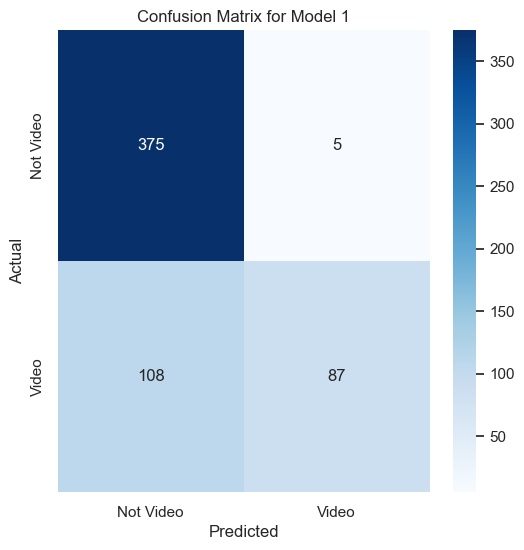

In [34]:
# Training the logistic regression model for Model 1
lr_model_1 = LogisticRegression(max_iter=1000)
lr_model_1.fit(x_train_1_scaled, y_train_1)

# Predicting the outcomes on the test set
y_pred_1 = lr_model_1.predict(x_test_1_scaled)

# Calculating the confusion matrix
conf_matrix_1 = confusion_matrix(y_test_1, y_pred_1)
print("Confusion Matrix:\n", conf_matrix_1)

# Plotting the confusion matrix manually using seaborn
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Not Video", "Video"], 
            yticklabels=["Not Video", "Video"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Model 1')
plt.show()

In the context of Facebook Live sellers in Thailand, the confusion matrix for Model 1 provides valuable insights into the model's performance, specifically in recognizing video content, which is a key component of engagement and sales in the burgeoning area of live streaming commerce.

__True Negatives (TN, 375):__ These represent posts that were correctly identified as not being videos. For Facebook Live sellers, this means the model is accurately filtering out content that does not require the same level of engagement or investment as live videos. Ensuring a high TN rate is crucial as it maintains efficiency in content strategy.

__False Positives (FP, 5):__ These are non-video posts that were incorrectly classified as videos. While the number is low, each FP could mislead sellers into dedicating resources towards engaging with content that may not yield the same return as videos. In a highly competitive market, resources need to be allocated effectively, and even small errors could affect the overall engagement strategy.

__False Negatives (FN, 108):__ This is the most critical error for our case. Live video content is central to the sellers' engagement with their audience, often leading to direct sales. Each FN represents a missed opportunity where a potentially high-engagement live video is not recognized as such, potentially leading to a significant loss in engagement and sales opportunities. Given the dataset indicates that live videos generate a high number of 'love' reactions, failing to identify these could mean not fully capitalizing on the most impactful content.

__True Positives (TP, 87):__ Posts that were accurately identified as videos. This shows the model is somewhat effective at picking out video content, which is likely to drive the most engagement and potential sales, but there is room for improvement.

Given the sales-driven nature of the Facebook Live platform for these Thai retailers, and considering the direct impact of video content on customer engagement and sales, controlling for False Negatives is more critical than False Positives. Every video post that goes unrecognized could mean a direct loss of revenue and a missed chance to strengthen customer relationships. Therefore, the focus should be on reducing FNs, even at the risk of slightly increasing FPs, to ensure all potential engagement and sales opportunities are captured.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> REFERENCES </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

[1] Jr., T. T. (2022, January 4). PCA 102: Should you use PCA? How many components to use? How to interpret them? Medium. https://towardsdatascience.com/pca-102-should-you-use-pca-how-many-components-to-use-how-to-interpret-them-da0c8e3b11f0#:~:text=The%20common%20way%20of%20selecting,as%20possible%20of%20that%20threshold

[2] Dehouche, N. (2020, June 1). Dataset on usage and engagement patterns for Facebook Live sellers in Thailand. https://www.sciencedirect.com/science/article/pii/S2352340920305552